# **Hotel Reservations Churn Predictive Model**


---


The landscape of hotel reservations has undergone a major transformation with
the advent of online booking platforms, leading to shifts in customer booking patterns. A considerable amount of hotel reservations face cancellations or no-shows, typically attributed to reasons such as changes in plans or scheduling conflicts. The ease of cancellation, often at minimal or no cost, benefits hotel guests but poses challenges for hotels as it may impact revenue negatively.

The dataset was extracted from Kaggle. Here's a link to the dataset: [Hotel Reservations Dataset](https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset)

Let's come up with a predictive model to predict if customers will honor or cancel their reservations.

# Overview

The data we're dealing is from 2 hotels in Portugal. The data has 36275 observations and 19 features including the target variable booking_status that we're traing to predict. This target variable is a binary variable and indicates whether a customer did honor their reservation or not. We will therefore use different binary classifiers to try to predict the target variable.

The dataset contains the following variables:

*   Booking_ID: unique identifier of each booking
*   no_of_adults: Number of adults
*   no_of_children: Number of Children
*   no_of_weekend_nights: Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel
*   no_of_week_nights: Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel
*   type_of_meal_plan: Type of meal plan booked by the customer
*   required_car_parking_space: Does the customer require a car parking space? (0 - No, 1- Yes)
*   room_type_reserved: Type of room reserved by the customer. The values are ciphered (encoded) by INN Hotels
*   lead_time: Number of days between the date of booking and the arrival date
*   arrival_year: Year of arrival date
*   arrival_month: Month of arrival date
*   arrival_date: Day of the month
*   market_segment_type: Market segment designation.
*   repeated_guest: Is the customer a repeated guest? (0 - No, 1- Yes)
*   no_of_previous_cancellations: Number of previous bookings that were canceled by the customer prior to the current booking
*   no_of_previous_bookings_not_canceled: Number of previous bookings not canceled by the customer prior to the current booking
*   avg_price_per_room: Average price per day of the reservation; prices of the rooms are dynamic. (in euros)
*   no_of_special_requests: Total number of special requests made by the customer (e.g. high floor, view from the room, etc)

Which will let us determine the target variable which is:

*   booking_status: Flag indicating if the booking was canceled or not

# Research Questions

1. Prediction Accuracy: How effectively can machine learning models predict the likelihood of a reservation being canceled based on available data?

2. Contribution to Cancellations: What are the primary factors influencing guests' decisions to cancel their hotel reservations?

3. Lead Time Influence on Cancellations: How does the duration of lead time between the booking and arrival date impact the probability of a reservation being canceled?

Importing relevant packages and library and previewing the dataset we're working with

In [1]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 7.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import f_oneway, f, chi2_contingency, pearsonr
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay, auc
import shap
from sklearn.pipeline import Pipeline

In [3]:
# Confusion Matrix returns in the format: cm[0,0], cm[0,1], cm[1,0], cm[1,1]: tn, fp, fn, tp

# Sensitivity
def custom_sensitivity_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return (tp/(tp+fn))

# Specificity
def custom_specificity_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return (tn/(tn+fp))

# Positive Predictive Value
def custom_ppv_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return (tp/(tp+fp))

# Negative Predictive Value
def custom_npv_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return (tn/(tn+fn))

# Accuracy
def custom_accuracy_score(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm[0][0], cm[0][1], cm[1][0], cm[1][1]
    return ((tn+tp)/(tn+tp+fn+fp))

In [4]:
# Load the hotel reservations dataset (assuming it's in a CSV file)
data = pd.read_csv('Hotel Reservations.csv')
data.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


# 1. How effectively can machine learning models predict the likelihood of a reservation being canceled based on available data?
# Pipeline: Logistic Regression, Random Forest, SVC

In [5]:
df2 = data.copy()
df2['booking_status'] = df2['booking_status'].apply(lambda x: 1 if x == 'Canceled' else 0)

X = df2.drop(["Booking_ID", 'booking_status'], axis=1)
y = df2['booking_status']

numerical_cols = X.select_dtypes(include=np.number).columns
categorical_cols = X.select_dtypes(exclude=np.number).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Evaluating model performance: Accuracy & ROC-AUC score

In [6]:
# Preprocessing for numerical data
numerical_transformer = StandardScaler()

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Define the models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVC': SVC(probability=True, random_state=42)  # Setting probability=True for ROC curve later
}

# Create and evaluate pipelines for each model
for model_name, model in models.items():
    # Create the pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', model)])

    # Fit the pipeline to the training data
    pipeline.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = pipeline.predict(X_test)

    # Evaluate the model's performance (e.g., accuracy)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'{model_name} - Test Accuracy: {accuracy:.4f}')

    # Calculate ROC-AUC score
    roc_auc = roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])
    print(f'{model_name} - ROC-AUC Score: {roc_auc:.4f}')

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression - Test Accuracy: 0.8069
Logistic Regression - ROC-AUC Score: 0.8643
Random Forest - Test Accuracy: 0.9048
Random Forest - ROC-AUC Score: 0.9608
SVC - Test Accuracy: 0.8433
SVC - ROC-AUC Score: 0.9028


## Selecting Random Forest Model to perform hyperparameter tuning

In [7]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
            ('model', RandomForestClassifier(random_state=42))])


### Grid Search CV on Random Forest

In [8]:
# Define the parameter grid for hyperparameter tuning specific to Random Forest
#param_grid = {
  #  'model__n_estimators': [100, 200, 300],
  #  'model__max_depth': [None, 10, 20, 30],
  #  'model__min_samples_split': [2, 5, 10],
  #  'model__min_samples_leaf': [1, 2, 4],
  # 'model__max_features': ['auto', 'sqrt', 'log2'],
  #  'model__bootstrap': [True],
  #  'model__criterion': ['gini', 'entropy'],
  #  'model__class_weight': [None, 'balanced']
#}

# Create a GridSearchCV object
#grid_search = GridSearchCV(
 #   pipeline,  # Your pipeline
  #  param_grid=param_grid,
   # scoring='roc_auc',  # Use ROC-AUC as one of the evaluation metrics
    #cv=5,  # Number of cross-validation folds
    #verbose=2,  # Increase verbosity for progress updates
    #n_jobs=-1  # Use all available CPU cores for parallelization
#)

# Fit GridSearchCV to the training data
#grid_search.fit(X_train, y_train)

# Get the best hyperparameters and model
#best_params = grid_search.best_params_
#best_model = grid_search.best_estimator_

# Evaluate the best model on test data
#y_pred = best_model.predict(X_test)
#roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])
#accuracy = accuracy_score(y_test, y_pred)

#print(f'Best Model - Test ROC-AUC Score: {roc_auc:.4f}')
#print(f'Best Model - Test Accuracy: {accuracy:.4f}')


### Random Search CV on Random Forest

In [9]:
param_dist = {
    'model__n_estimators': [100, 200, 300, 400],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10, 15],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['auto', 'sqrt', 'log2'],
    'model__bootstrap': [True, False],
    'model__criterion': ['gini', 'entropy'],
    'model__class_weight': [None, 'balanced']
}

random_search = RandomizedSearchCV(
    pipeline,  # Your pipeline
    param_distributions=param_dist,
    n_iter=100,  # Number of random parameter combinations to try
    scoring='roc_auc',  # Use ROC-AUC as one of the evaluation metrics
    cv=5,  # Number of cross-validation folds
    verbose=2,  # Increase verbosity for progress updates
    n_jobs=-1  # Use all available CPU cores for parallelization
)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_model = random_search.best_estimator_

y_pred = best_model.predict(X_test)
roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])
accuracy = accuracy_score(y_test, y_pred)

print(f'Best Model - Test ROC-AUC Score: {roc_auc:.4f}')
print(f'Best Model - Test Accuracy: {accuracy:.4f}')


Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best Model - Test ROC-AUC Score: 0.9625
Best Model - Test Accuracy: 0.9038


In [10]:
best_params

{'model__n_estimators': 300,
 'model__min_samples_split': 10,
 'model__min_samples_leaf': 1,
 'model__max_features': 'auto',
 'model__max_depth': None,
 'model__criterion': 'entropy',
 'model__class_weight': 'balanced',
 'model__bootstrap': False}

## Random Forest Confusion Matrix

In [11]:
df5 = data.copy()
df5['booking_status'] = df5['booking_status'].apply(lambda x: 1 if x == 'Canceled' else 0)

X = df5.drop(["Booking_ID", 'booking_status'], axis=1)
y = df5['booking_status']

numerical_cols = X.select_dtypes(include=np.number).columns
categorical_cols = X.select_dtypes(exclude=np.number).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

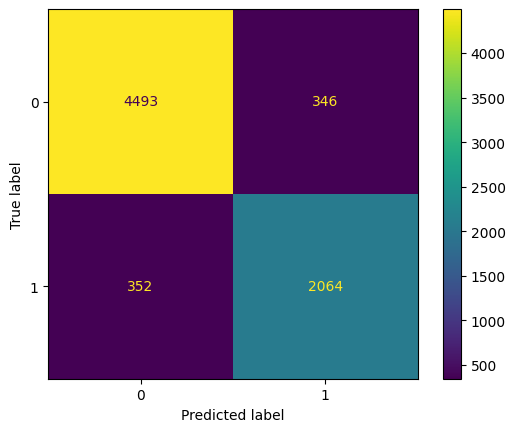

Metrics of the logistic regression model: 

                                   Accuracy: 0.9037904893177119
                   SENSITIVITY (aka RECALL): 0.8543046357615894
                 SPECIFICITY (aka FALL-OUT): 0.9284976234759248
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.8564315352697095
                 NEGATIVE PREDICTIVE VALUE): 0.9273477812177503


In [12]:
rf_predictions = best_model.predict(X_test)
rf_predictions_prob = best_model.predict_proba(X_test)[:,1]

# Create and plot the confusion matrix
cm = confusion_matrix(y_test, rf_predictions, labels=best_model.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=best_model.classes_)
disp.plot()
plt.show()

# Let's look at the model metrics
print('Metrics of the logistic regression model: \n')

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, rf_predictions)))
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, rf_predictions)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, rf_predictions)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, rf_predictions)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, rf_predictions)))


fpr, tpr, thresholds = roc_curve(y_test, rf_predictions_prob)

fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels={'x':'1 - Specificity', 'y':'Sensitivity'}
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)
fig.show()

## Selecting Logistic Regression Model to perform hyperparameter tuning

### Grid Search CV

In [13]:
pipeline_lr = Pipeline(steps=[('preprocessor', preprocessor),
            ('model', LogisticRegression(random_state=42))])

In [14]:
param_grid = {
    'model__C': [0.001, 0.01, 0.1, 1, 10],
    'model__penalty': ['l1', 'l2'],
    'model__solver': ['liblinear', 'saga'],
    'model__max_iter': [100, 500, 1000]  # Add max_iter values to the hyperparameter grid
}

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(pipeline_lr, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = {k.replace('model__', ''): v for k, v in grid_search.best_params_.items()}

print("Adjusted Best Hyperparameters for Logistic Regression:", best_params)

pipeline_lr_best = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(**best_params, random_state=42))
])
pipeline_lr_best.fit(X_train, y_train)

# Evaluate the best model on the holdout test set
test_accuracy = pipeline_lr_best.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

Adjusted Best Hyperparameters for Logistic Regression: {'C': 0.01, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Test Accuracy: 0.8035837353549277


In [15]:
best_params

{'C': 0.01, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}

## Logistic Regression Confusion Matrix

In [16]:
df3 = data.copy()

df3['booking_status'] = df3['booking_status'].apply(lambda x: 1 if x == 'Canceled' else 0)

one_hot_encoder = OneHotEncoder(sparse=False, drop='first')
encoded_cols = one_hot_encoder.fit_transform(df3[['type_of_meal_plan', 'room_type_reserved', 'market_segment_type']])

# Get the feature names for the one-hot encoded columns
encoded_col_names = one_hot_encoder.get_feature_names_out(['type_of_meal_plan', 'room_type_reserved', 'market_segment_type'])

# Create a DataFrame with the encoded columns and set the column names
encoded_df = pd.DataFrame(encoded_cols, columns=encoded_col_names)

# Concatenate the new DataFrame with the original DataFrame
df3 = pd.concat([df3, encoded_df], axis=1)

# Drop the original categorical columns
df3.drop(['type_of_meal_plan', 'room_type_reserved', 'market_segment_type'], axis=1, inplace=True)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



In [17]:
X = df3.drop(["Booking_ID", 'booking_status'], axis=1)
y = df3['booking_status']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

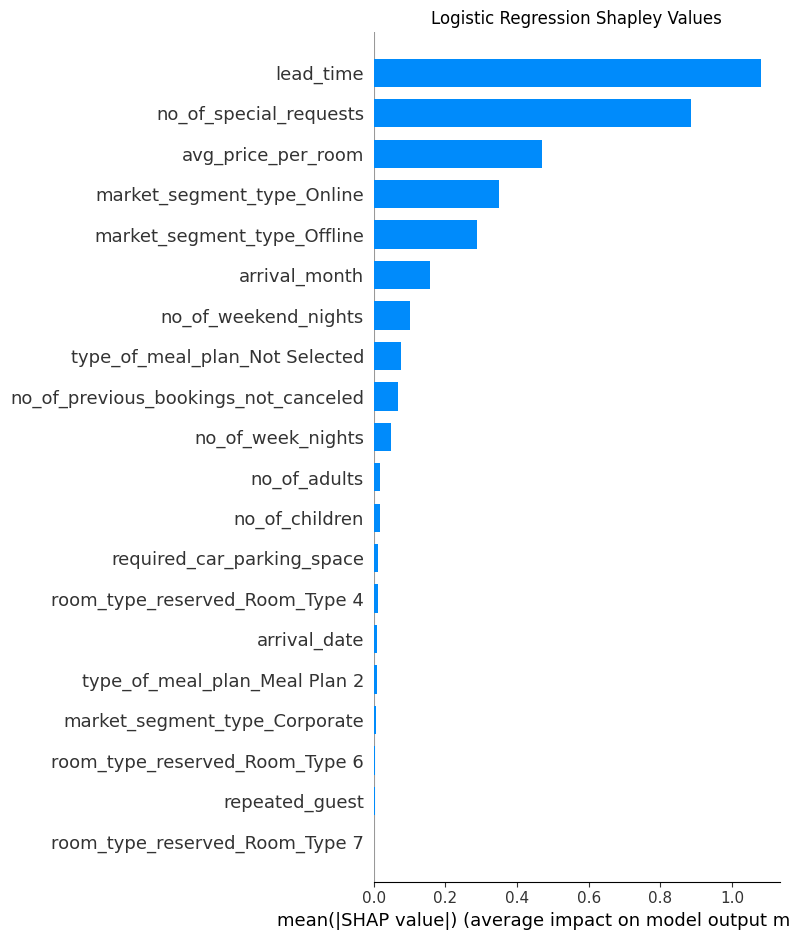

In [19]:
lr_model = LogisticRegression(C=0.01, max_iter=100, penalty='l2', solver='liblinear')
lr_model.fit(X_train, y_train)

lr_explainer = shap.Explainer(lr_model, X_train)

lr_shap_values = lr_explainer.shap_values(X_test)

plt.figure(figsize=(20, 20))
plt.title("Logistic Regression Shapley Values")
shap.summary_plot(lr_shap_values, X_test, feature_names=X.columns, plot_type="bar")

plt.show()

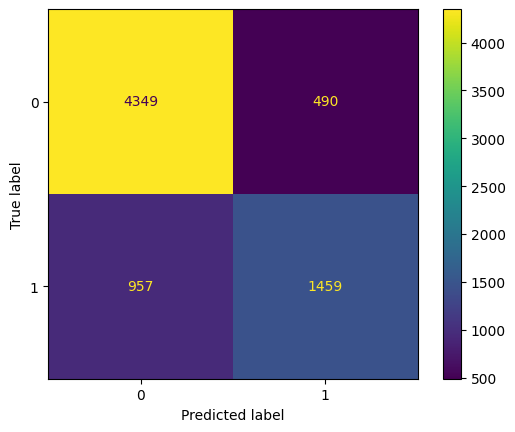

Metrics of the logistic regression model: 

                                   Accuracy: 0.8005513439007581
                   SENSITIVITY (aka RECALL): 0.6038907284768212
                 SPECIFICITY (aka FALL-OUT): 0.8987394089687952
 POSITIVE PREDICTIVE VALUE, (aka PRECISION): 0.7485890200102616
                 NEGATIVE PREDICTIVE VALUE): 0.8196381454956653


In [20]:
lr_predictions = lr_model.predict(X_test)
lr_predictions_prob = lr_model.predict_proba(X_test)[:,1]

# Create and plot the confusion matrix
cm = confusion_matrix(y_test, lr_predictions, labels=lr_model.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=lr_model.classes_)
disp.plot()
plt.show()

# Let's look at the model metrics
print('Metrics of the logistic regression model: \n')

print("                                   Accuracy: " + str(custom_accuracy_score(y_test, lr_predictions)))
print("                   SENSITIVITY (aka RECALL): " + str(custom_sensitivity_score(y_test, lr_predictions)))
print("                 SPECIFICITY (aka FALL-OUT): " + str(custom_specificity_score(y_test, lr_predictions)))
print(" POSITIVE PREDICTIVE VALUE, (aka PRECISION): " + str(custom_ppv_score(y_test, lr_predictions)))
print("                 NEGATIVE PREDICTIVE VALUE): " + str(custom_npv_score(y_test, lr_predictions)))


fpr, tpr, thresholds = roc_curve(y_test, lr_predictions_prob)

fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels={'x':'1 - Specificity', 'y':'Sensitivity'}
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)
fig.show()

# 2. What are the primary factors influencing guests' decisions to cancel their hotel reservations?

In [23]:
df6 = data.copy()
df6['booking_status'] = df6['booking_status'].apply(lambda x: 1 if x == 'Canceled' else 0)

X = df6.drop(["Booking_ID", 'booking_status'], axis=1)
y = df6['booking_status']

numerical_cols = X.select_dtypes(include=np.number).columns
categorical_cols = X.select_dtypes(exclude=np.number).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

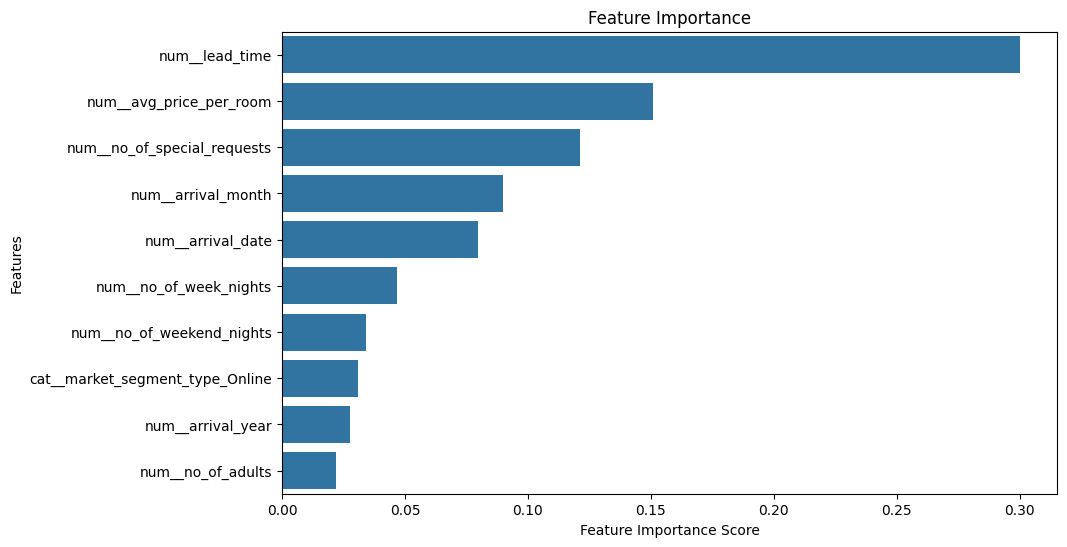

In [24]:
# Fit the preprocessor on your training data
preprocessor = best_model.named_steps['preprocessor']
preprocessor.fit(X_train)

# Get the feature names from the preprocessor
# This code depends on how your preprocessor is structured
if hasattr(preprocessor, 'get_feature_names_out'):
    # For newer versions of scikit-learn
    feature_names = preprocessor.get_feature_names_out()
else:
    # Extract feature names manually for older versions
    # This will vary based on your exact preprocessing steps
    num_features = list(numerical_cols)
    cat_features = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols)
    feature_names = num_features + list(cat_features)

# Now get the feature importances from the model
random_forest_model = best_model.named_steps['model']
feature_importances = random_forest_model.feature_importances_

# Ensure the number of feature importances matches the number of features
assert len(feature_importances) == len(feature_names)

# Top 10 features
top_n = 10

# Sorting and selecting top N features
sorted_idx = np.argsort(feature_importances)[::-1]
top_feature_names = feature_names[sorted_idx][:top_n]
top_feature_importances = feature_importances[sorted_idx][:top_n]

# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x=top_feature_importances, y=top_feature_names)
plt.title('Feature Importance')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.show()

# 3. Does the lead time between booking and arrival date affect the likelihood of cancellation?

In [25]:
# Data Preprocessing
df = data.copy()

df['booking_status'] = df['booking_status'].apply(lambda x: 1 if x == 'Canceled' else 0)

canceled_bookings = df[df['booking_status'] == 1]
honored_bookings = df[df['booking_status'] == 0]

In [26]:
honored_bookings

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,0
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,0
6,INN00007,2,0,1,3,Meal Plan 1,0,Room_Type 1,34,2017,10,15,Online,0,0,0,107.55,1,0
7,INN00008,2,0,1,3,Meal Plan 1,0,Room_Type 4,83,2018,12,26,Online,0,0,0,105.61,1,0
8,INN00009,3,0,0,4,Meal Plan 1,0,Room_Type 1,121,2018,7,6,Offline,0,0,0,96.90,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36263,INN36264,1,0,2,1,Meal Plan 1,0,Room_Type 1,116,2018,2,28,Online,0,0,0,1.00,0,0
36265,INN36266,2,0,1,3,Meal Plan 1,0,Room_Type 1,15,2018,5,30,Online,0,0,0,100.73,0,0
36270,INN36271,3,0,2,6,Meal Plan 1,0,Room_Type 4,85,2018,8,3,Online,0,0,0,167.80,1,0
36272,INN36273,2,0,2,6,Meal Plan 1,0,Room_Type 1,148,2018,7,1,Online,0,0,0,98.39,2,0


In [27]:
# Checking for null values in lead_time
df['lead_time'].isna().sum()

0

In [28]:
df['lead_time'].describe()

count    36275.000000
mean        85.232557
std         85.930817
min          0.000000
25%         17.000000
50%         57.000000
75%        126.000000
max        443.000000
Name: lead_time, dtype: float64

##Splitting lead_time into 3 categories: Short Lead Time (< 57 days), Medium Lead Time (57 days < lead_time <= 126 days), and Long Lead Time (> 126 days)

In [29]:
# Define custom lead time categories based on your criteria
def categorize_lead_time(lead_time):
    if lead_time <= 57:
        return 'Short Lead Time (< 57 days)'
    elif 57 < lead_time <= 126:
        return 'Medium Lead Time (57 days < lead_time <= 126 days)'
    else:
        return 'Long Lead Time (> 126 days)'

# Create 'lead_time_category' based on custom lead time categories
df['lead_time_category'] = df['lead_time'].apply(categorize_lead_time)

In [30]:
# Encode categorical variables (e.g., 'lead_time_category')
label_encoder = LabelEncoder()
df['lead_time_category'] = label_encoder.fit_transform(df['lead_time_category'])

In [31]:
print(df['lead_time'].head())
print(df['lead_time_category'].head())

0    224
1      5
2      1
3    211
4     48
Name: lead_time, dtype: int64
0    0
1    2
2    2
3    0
4    2
Name: lead_time_category, dtype: int64


In [32]:
# Statistical Analysis (ANOVA)
lead_time_categories = [df[df['lead_time_category'] == category]['booking_status'] for category in df['lead_time_category'].unique()]
f_statistic, p_value = f_oneway(*lead_time_categories)

# Interpretation
print(f'ANOVA F-statistic: {f_statistic:.2f}')
print(f'ANOVA p-value: {p_value:.4f}')

if p_value < 0.05:
    print('There is a significant difference in cancellation rates among lead time categories.')
else:
    print('There is no significant difference in cancellation rates among lead time categories.')

ANOVA F-statistic: 3659.69
ANOVA p-value: 0.0000
There is a significant difference in cancellation rates among lead time categories.


<ipython-input-33-f86ed8d2b798>:10: UserWarning:

FixedFormatter should only be used together with FixedLocator



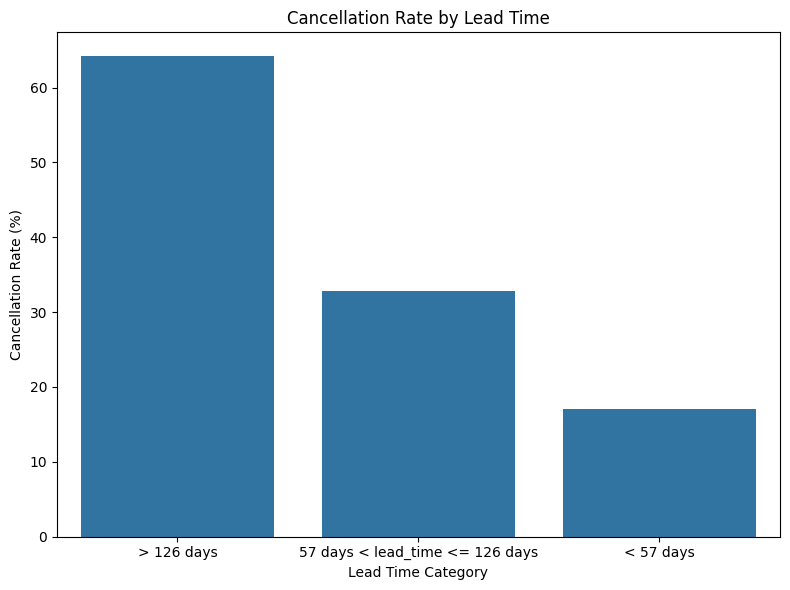

In [33]:
lead_time_groups = df.groupby('lead_time_category')
cancellation_rates = lead_time_groups['booking_status'].mean() * 100

plt.figure(figsize=(8, 6))
ax = sns.barplot(x=cancellation_rates.index, y=cancellation_rates.values)
plt.xlabel('Lead Time Category')
plt.ylabel('Cancellation Rate (%)')
plt.title('Cancellation Rate by Lead Time')
ax = plt.gca()
ax.set_xticklabels(['> 126 days', '57 days < lead_time <= 126 days', '< 57 days'])
plt.tight_layout()
plt.show()

## Histogram and boxplot of lead_time for booking_status

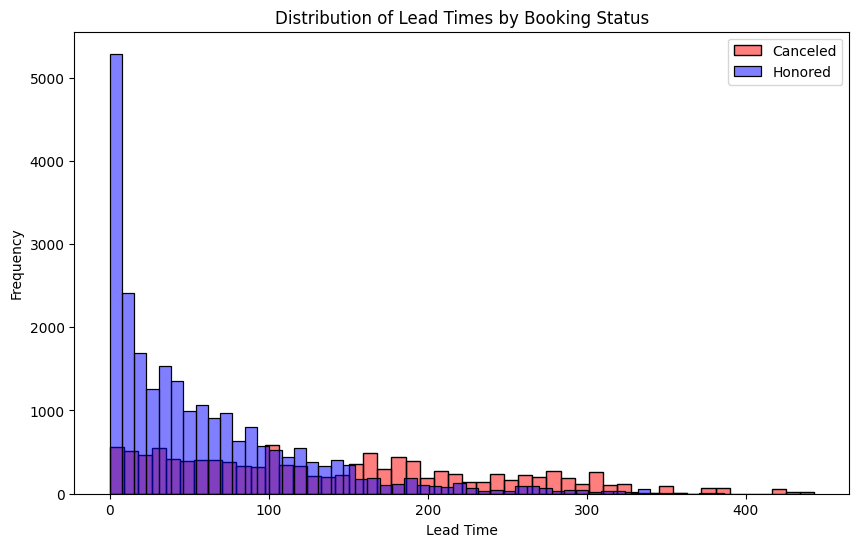

In [34]:
plt.figure(figsize=(10, 6))
sns.histplot(data=canceled_bookings['lead_time'], bins=50, color='red', alpha=0.5, label='Canceled')
sns.histplot(data=honored_bookings['lead_time'], bins=50, color='blue', alpha=0.5, label='Honored')
plt.xlabel('Lead Time')
plt.ylabel('Frequency')
plt.title('Distribution of Lead Times by Booking Status')
plt.legend()
plt.show()

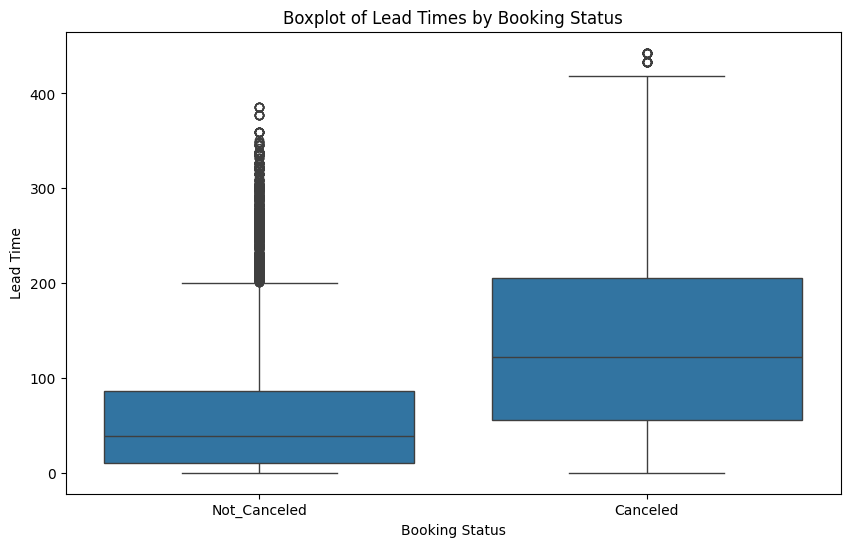

In [35]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='booking_status', y='lead_time', data=data)
plt.xlabel('Booking Status')
plt.ylabel('Lead Time')
plt.title('Boxplot of Lead Times by Booking Status')
plt.show()